---

### import 

In [1]:
import torch 
from fastai.vision.all import *
import cv2

In [2]:
import numpy as np

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
from torchvision.utils import save_image
import os

In [6]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [7]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [8]:
import pickle

---

### Simulation

### - 여기서는 `랜덤박스가 추가된 개/고양이 그림`에 대해 CAM을 진행한 결과를 확인함

#### (1) 랜덤박스가 들어간 개 고양이 그림 

In [9]:
path=Path('random_pet_one')   #랜덤박스넣은사진

In [10]:
path.ls()

(#7391) [Path('random_pet_one/Bombay_13.jpg'),Path('random_pet_one/beagle_193.jpg'),Path('random_pet_one/Ragdoll_8.jpg'),Path('random_pet_one/boxer_106.jpg'),Path('random_pet_one/keeshond_56.jpg'),Path('random_pet_one/american_pit_bull_terrier_162.jpg'),Path('random_pet_one/saint_bernard_136.jpg'),Path('random_pet_one/staffordshire_bull_terrier_76.jpg'),Path('random_pet_one/pug_173.jpg'),Path('random_pet_one/american_pit_bull_terrier_117.jpg')...]

In [11]:
files=get_image_files(path)

In [12]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

#### (2) 학습 

In [13]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.127810,0.003895,0.000677,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.001968,0.000031,0.000000,00:46


In [14]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [15]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [16]:
net=torch.nn.Sequential(net1,net2)

In [17]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [18]:
lrnr2.fine_tune(10) 

epoch,train_loss,valid_loss,accuracy,time
0,0.008669,0.000151,1.000000,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.000115,0.000000,1.000000,00:46
1,0.000027,0.000003,1.000000,00:46
2,0.000006,0.000002,1.000000,00:46
3,0.000002,0.000001,1.000000,00:46
4,0.000001,0.000000,1.000000,00:46
5,0.000001,0.000000,1.000000,00:46
6,0.000000,0.000000,1.000000,00:46
7,0.000000,0.000000,1.000000,00:46
8,0.000000,0.000000,1.000000,00:46
9,0.000000,0.000000,1.000000,00:46


---

# Step by step

# DOG

In [19]:
x_dog, = first(dls.test_dl([PILImage.create(get_image_files(path)[12])]))

In [20]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x_dog).squeeze())

In [21]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

power_threshed=np.array(ebayesthresh(FloatVector(torch.tensor(camimg[0].detach().reshape(-1))**2)))
ybar_threshed = np.where(power_threshed>1600,torch.tensor(camimg[0].detach().reshape(-1)).to('cpu'),0)
ybar_threshed = torch.tensor(ybar_threshed.reshape(16,16))

power_threshed2=np.array(ebayesthresh(FloatVector(torch.tensor(camimg[1].detach().reshape(-1))**2)))
ybar_threshed2 = np.where(power_threshed2>2100,torch.tensor(camimg[1].detach().reshape(-1)).to('cpu'),0)
ybar_threshed2 = torch.tensor(ybar_threshed2.reshape(16,16))

<ipython-input-21-9fef2ba92a04>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed=np.array(ebayesthresh(FloatVector(torch.tensor(camimg[0].detach().reshape(-1))**2)))
<ipython-input-21-9fef2ba92a04>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ybar_threshed = np.where(power_threshed>1600,torch.tensor(camimg[0].detach().reshape(-1)).to('cpu'),0)
<ipython-input-21-9fef2ba92a04>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed2=np.array(ebayesthresh(FloatVector(torch.tensor(camimg[1].detach().reshape(-1))**2)

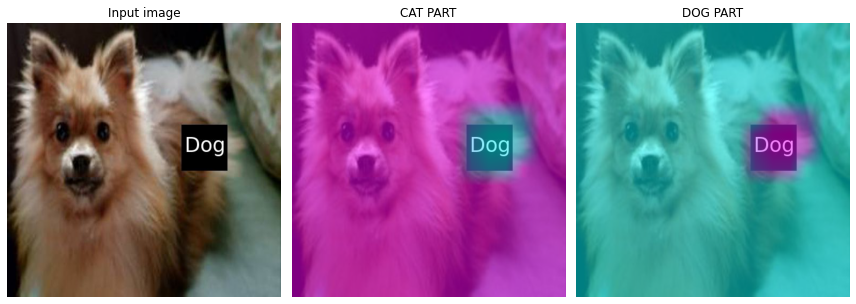

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax2)
ax2.imshow((ybar_threshed).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax3)
ax3.imshow((ybar_threshed2).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

- 판단 근거가 강할 수록 파란색 -> 보라색

In [23]:
a,b = net(x_dog).tolist()[0]

In [24]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

(1.326095209472736e-08, 0.9999999867390479)

## mode 1

In [25]:
# test=camimg_o[0]-torch.min(camimg_o[0])
A1=torch.exp(-0.05*(ybar_threshed2))
A2 = 1 - A1

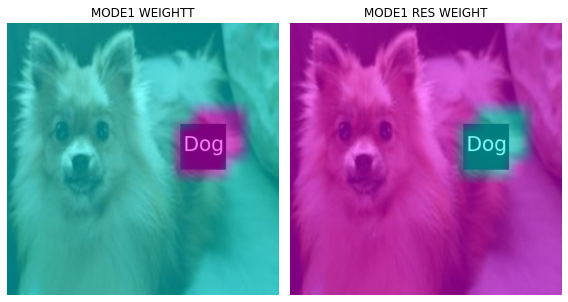

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHTT")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [27]:
# mode 1 res
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
x1=x_dog.squeeze().to('cpu')*Y1-torch.min(x_dog.squeeze().to('cpu'))*Y1

# mode 1
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(512,512),interpolation=cv2.INTER_LINEAR))
x12=x_dog.squeeze().to('cpu')*Y12-torch.min(x_dog.squeeze().to('cpu'))*Y12

`-` 1st CAM 분리

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


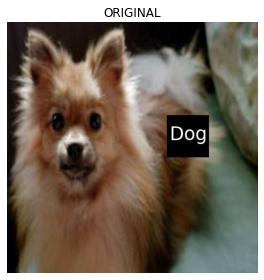

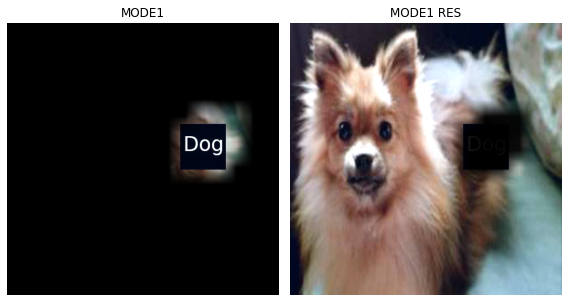

In [28]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
(x1*0.3).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [29]:
x1 = x1.reshape(1,3,512,512)

In [30]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [31]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

In [32]:
power_threshed3=np.array(ebayesthresh(FloatVector(torch.tensor(camimg1[0].detach().reshape(-1))**2)))
ybar_threshed3 = np.where(power_threshed3>10,torch.tensor(camimg1[0].detach().reshape(-1)),0)
ybar_threshed3 = torch.tensor(ybar_threshed3.reshape(16,16))

power_threshed4=np.array(ebayesthresh(FloatVector(torch.tensor(camimg1[1].detach().reshape(-1))**2)))
ybar_threshed4 = np.where(power_threshed4>10,torch.tensor(camimg1[1].detach().reshape(-1)),0)
ybar_threshed4 = torch.tensor(ybar_threshed4.reshape(16,16))

<ipython-input-32-292f842a7fbc>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed3=np.array(ebayesthresh(FloatVector(torch.tensor(camimg1[0].detach().reshape(-1))**2)))
<ipython-input-32-292f842a7fbc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ybar_threshed3 = np.where(power_threshed3>10,torch.tensor(camimg1[0].detach().reshape(-1)),0)
<ipython-input-32-292f842a7fbc>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed4=np.array(ebayesthresh(FloatVector(torch.tensor(camimg1[1].detach().reshape(-1))**2)))
<ip

In [33]:
a1,b1 = net(x1).tolist()[0]

In [34]:
np.exp(a1)/ (np.exp(a1)+np.exp(b1)) ,  np.exp(b1)/ (np.exp(a1)+np.exp(b1))

(0.014474672732127929, 0.985525327267872)

`-` mode1 res 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


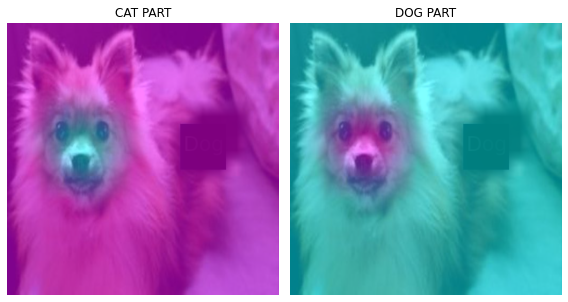

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
(x1*0.25).squeeze().show(ax=ax1)
ax1.imshow(ybar_threshed3,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
(x1*0.25).squeeze().show(ax=ax2)
ax2.imshow(ybar_threshed4,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

`-` 첫번째 CAM 결과와 비교

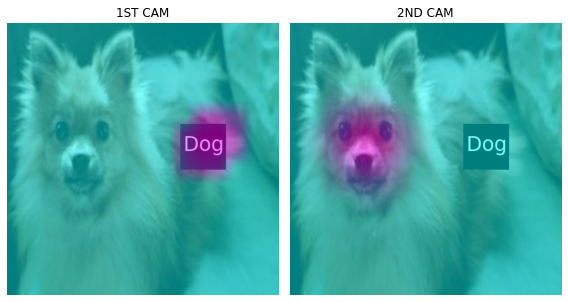

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.imshow(ybar_threshed2,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax2)
ax2.imshow(ybar_threshed4,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

`-` 2nd CAM 분리

In [37]:
# test1=camimg1[1]-torch.min(camimg1[1])
A3 = torch.exp(-0.05*(ybar_threshed4))
A4 = 1 - A3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


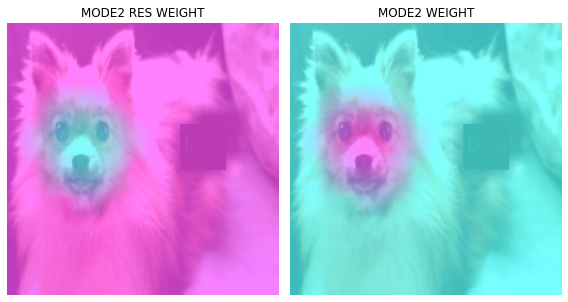

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax2)
dls.train.decode((x1,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 RES WEIGHT")
#
x1.squeeze().show(ax=ax2)
dls.train.decode((x1,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [39]:
# res 
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))
x2=(x1*0.2)*Y2-torch.min((x1*0.2)*Y2)
#
X22=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y22=torch.Tensor(cv2.resize(X22,(512,512),interpolation=cv2.INTER_LINEAR))
x22=(x1*0.2)*Y22-torch.min((x1*0.2)*Y22)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


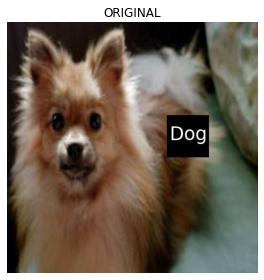

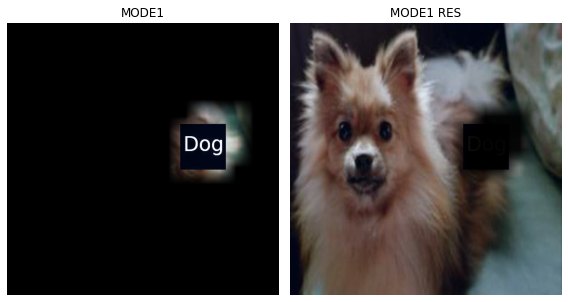

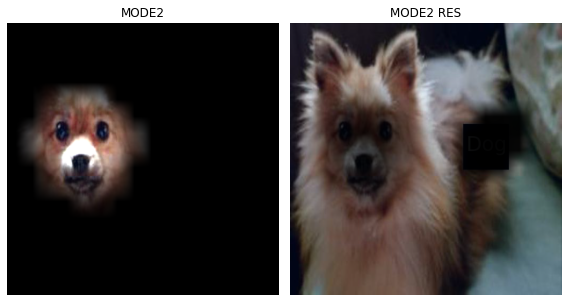

In [40]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
(x1*0.2).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x22*3).squeeze().show(ax=ax1)  #MODE2
(x2).squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [41]:
x2 = x2.reshape(1,3,512,512)

In [42]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [43]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

In [44]:
power_threshed5=np.array(ebayesthresh(FloatVector(torch.tensor(camimg2[0].detach().reshape(-1))**2)))
ybar_threshed5 = np.where(power_threshed5>4,torch.tensor(camimg2[0].detach().reshape(-1)),0)
ybar_threshed5 = torch.tensor(ybar_threshed5.reshape(16,16))

power_threshed6=np.array(ebayesthresh(FloatVector(torch.tensor(camimg2[1].detach().reshape(-1))**2)))
ybar_threshed6 = np.where(power_threshed6>4,torch.tensor(camimg1[1].detach().reshape(-1)),0)
ybar_threshed6 = torch.tensor(ybar_threshed6.reshape(16,16))

<ipython-input-44-25e0375ebe18>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed5=np.array(ebayesthresh(FloatVector(torch.tensor(camimg2[0].detach().reshape(-1))**2)))
<ipython-input-44-25e0375ebe18>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ybar_threshed5 = np.where(power_threshed5>4,torch.tensor(camimg2[0].detach().reshape(-1)),0)
<ipython-input-44-25e0375ebe18>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  power_threshed6=np.array(ebayesthresh(FloatVector(torch.tensor(camimg2[1].detach().reshape(-1))**2)))
<ipy

In [45]:
a2,b2 = net(x2).tolist()[0]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.1807078585239272, 0.8192921414760728)

`-` mode2 res 에 CAM 결과 올리기

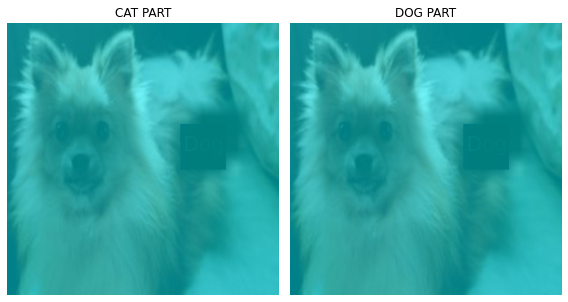

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x2.squeeze().show(ax=ax1)
ax1.imshow(ybar_threshed5,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x2.squeeze().show(ax=ax2)
ax2.imshow(ybar_threshed6,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

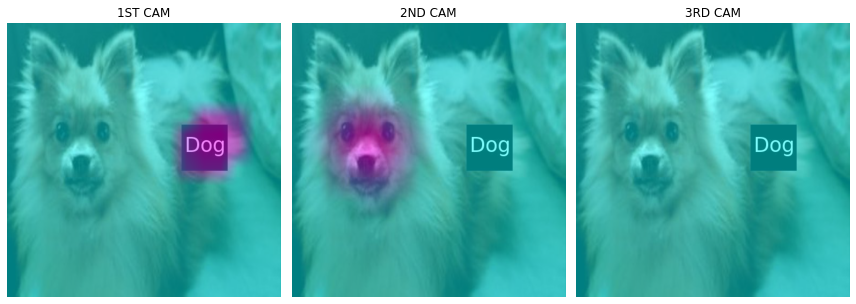

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.imshow(ybar_threshed2,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax2)
ax2.imshow(ybar_threshed4,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax3)
ax3.imshow(ybar_threshed6,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

## mode 3 만들기 더이상 분리되지 않는 듯

In [48]:
# test2=camimg2[1]-torch.min(camimg2[1])

In [49]:
A5 = torch.exp(-0.05*(ybar_threshed6))

In [50]:
A6 = 1 - A5

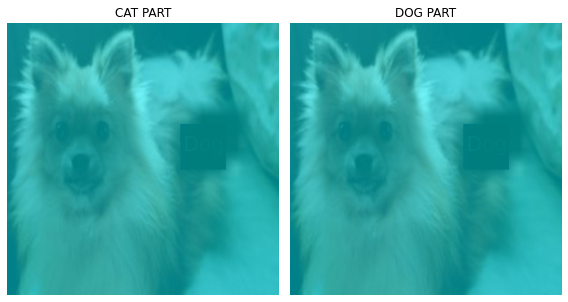

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x2.squeeze().show(ax=ax1)
ax1.imshow(ybar_threshed5,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x2.squeeze().show(ax=ax2)
ax2.imshow(ybar_threshed6,alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [52]:
#mode 3 res
X3=np.array(A5.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv2.resize(X3,(512,512),interpolation=cv2.INTER_LINEAR))
x3=x2*Y3-torch.min(x2*Y3)
# mode 3
X32=np.array(A6.to("cpu").detach(),dtype=np.float32)
Y32=torch.Tensor(cv2.resize(X32,(512,512),interpolation=cv2.INTER_LINEAR))
x32=x2*Y32-torch.min(x2*Y32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


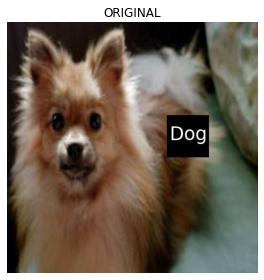

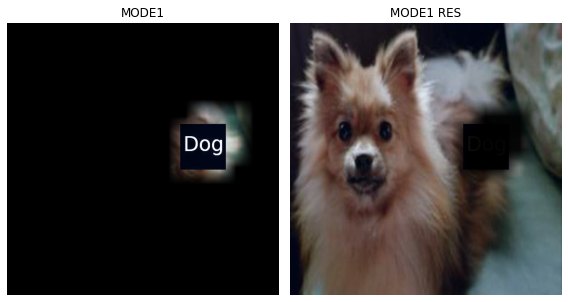

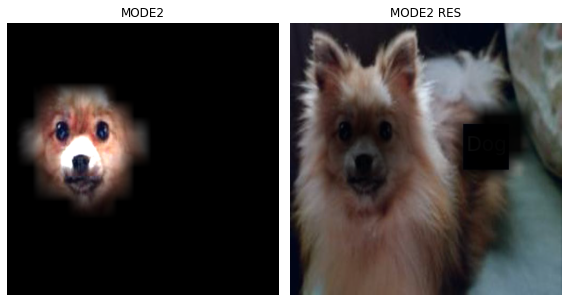

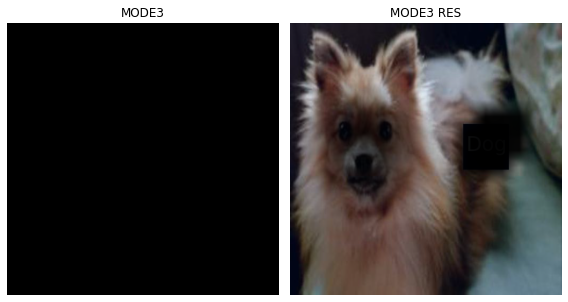

In [53]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x_dog,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()

with open('hcam_dog_plt1.pkl', 'wb') as file:
    pickle.dump(fig, file)
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
(x1*0.2).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt2.pkl', 'wb') as file:
    pickle.dump(fig, file)
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x22*4).squeeze().show(ax=ax1)  #MODE2
(x2).squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt3.pkl', 'wb') as file:
    pickle.dump(fig, file)
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x32*8).squeeze().show(ax=ax1)  #MODE3
(x3).squeeze().show(ax=ax2)  #MODE3_res
ax1.set_title("MODE3")
ax2.set_title("MODE3 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt4.pkl', 'wb') as file:
    pickle.dump(fig, file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


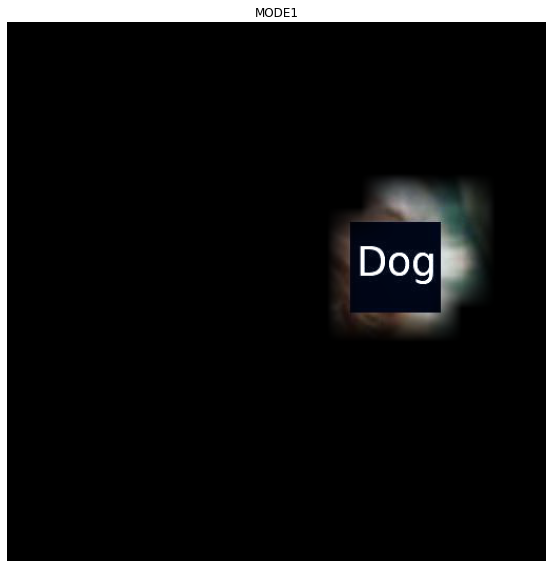

In [54]:
fig, (ax1) = plt.subplots(1,1) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
ax1.set_title("MODE1")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt_mode1.pkl', 'wb') as file:
    pickle.dump(fig, file)

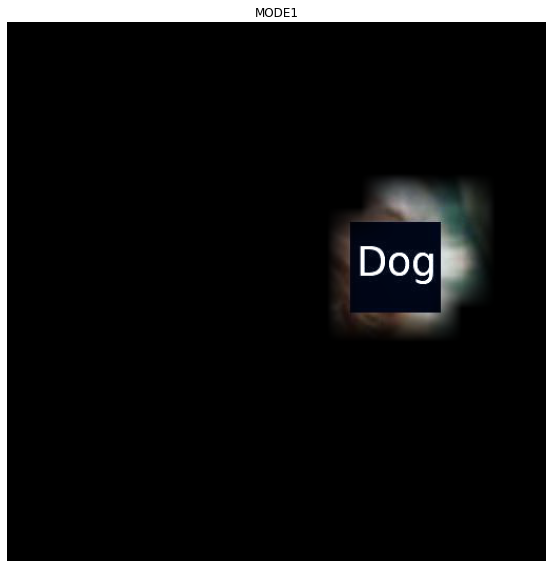

In [55]:
with open('hcam_dog_plt_mode1.pkl', 'rb') as file:
    hcam_dog_plt_mode1 = pickle.load(file)
plt.show(hcam_dog_plt_mode1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


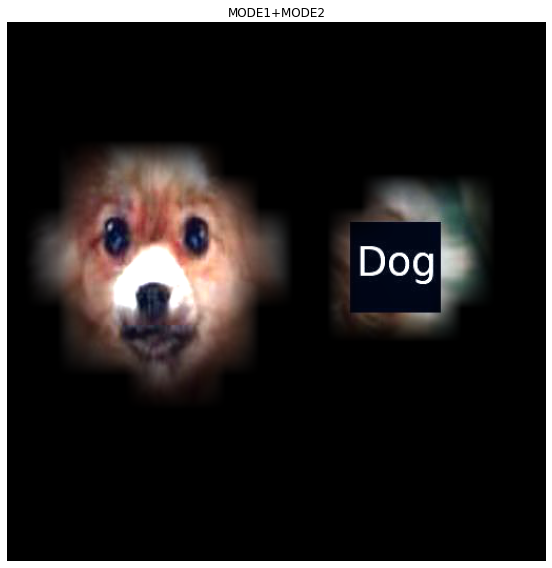

In [56]:
fig, (ax1) = plt.subplots(1,1) 
(x12*0.3 + x22*4).squeeze().show(ax=ax1)  #MODE1+MODE2
ax1.set_title("MODE1+MODE2")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt_mode2.pkl', 'wb') as file:
    pickle.dump(fig, file)

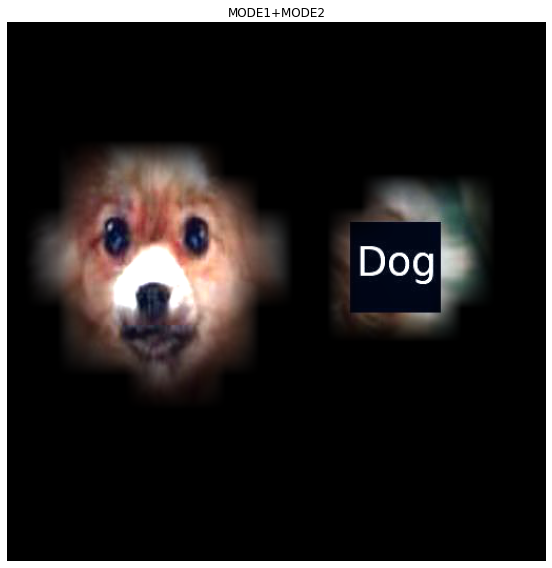

In [57]:
with open('hcam_dog_plt_mode2.pkl', 'rb') as file:
    hcam_dog_plt_mode2 = pickle.load(file)
plt.show(hcam_dog_plt_mode2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


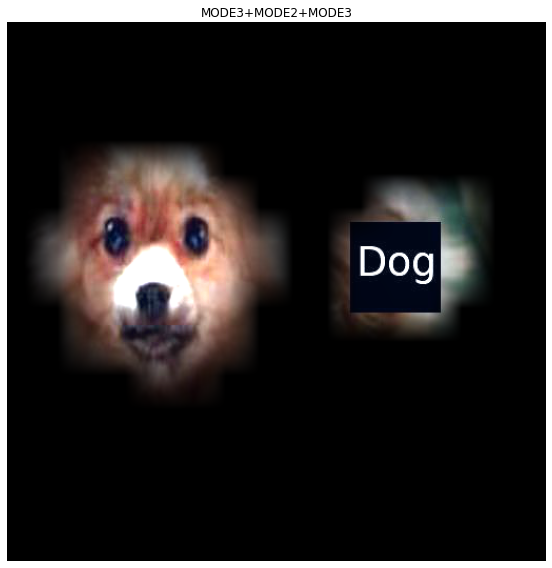

In [58]:
fig, (ax1) = plt.subplots(1,1) 
(x12*0.3 + x22*4 + x32*2).squeeze().show(ax=ax1)  #MODE1+MODE2+MODE3
ax1.set_title("MODE3+MODE2+MODE3")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

with open('hcam_dog_plt_mode3.pkl', 'wb') as file:
    pickle.dump(fig, file)

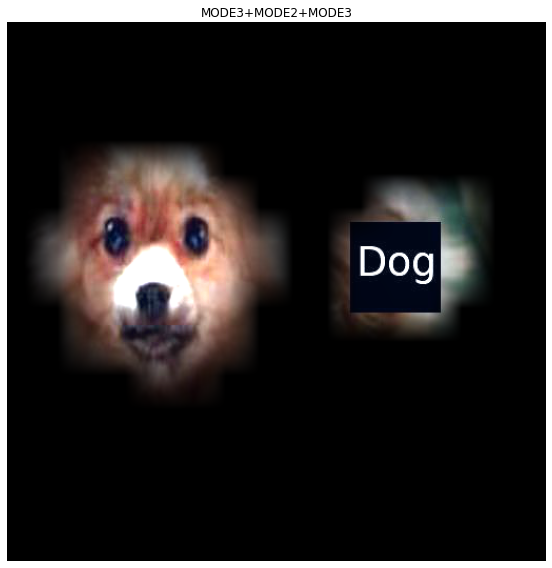

In [59]:
with open('hcam_dog_plt_mode3.pkl', 'rb') as file:
    hcam_dog_plt_mode3 = pickle.load(file)
plt.show(hcam_dog_plt_mode3)